## OpenCL and pyOpenCL


In [1]:
pip install pyopencl

     |████████████████████████████████| 884 kB 10.6 MB/s 
     |████████████████████████████████| 69 kB 7.7 MB/s 
  Created wheel for pytools: filename=pytools-2022.1.7-py2.py3-none-any.whl size=64772 sha256=5fe9a508b17f0aa4158fb0290f5e10dae96716e441e41093804f033541244d51
  Stored in directory: /root/.cache/pip/wheels/24/c3/8d/9b093180175460a5fc613220b26027ae97cecbbf94fd3822af
Successfully built pytools


In [96]:
import pyopencl as cl

ctx = cl.create_some_context(interactive=True)
devices = ctx.get_info(cl.context_info.DEVICES)
print(devices)

def fractal_gpu(C, N):

    global ctx
    
    queue = cl.CommandQueue(ctx)
    output = np.empty(C.shape, dtype=np.uint16)

    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void fractal(__global float2 *C,
                     __global ushort *output, ushort const N)
    {
        int n = get_global_id(0);
        float temp, real = 0;
        float imag = 0;
        output[n] = N;
        
        for(int idx = 0; idx < N; idx++) {
            temp = real*real - imag*imag + C[n].x;
            imag = 2* real*imag + C[n].y;
            real = temp;
            if (real*real + imag*imag > 4.0f){
                 output[n] = idx;
                 break;
            }
        }
        
    }
    """).build()

    mf = cl.mem_flags
    
    #mf.READ_ONLY - The OpenCL Kernels will only read the buffer

    C_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=C)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)


    prg.fractal(queue, output.shape, None, C_opencl, output_opencl, np.uint16(N))
    cl.enqueue_copy(queue, output, output_opencl)
    
    return output

import numpy as np
def generate_fractal(nx=1024, ny=1024, N=100):

    x_min = -2
    x_max = 0.5
    y_min = -1.25
    y_max = 1.25

    x = np.linspace(x_min, x_max, nx, dtype=np.float32)
    y = np.linspace(y_min, y_max, ny, dtype=np.float32)
    X, Y = np.meshgrid(x, y)
    C = X + 1j * Y
    C = np.ravel(C)
    
    Z = fractal_gpu(C, N)
    Z = Z.reshape((nx, ny))
    return Z

Choose platform:
[0] <pyopencl.Platform 'NVIDIA CUDA' at 0x2bdf310>
Choice [0]:0
Set the environment variable PYOPENCL_CTX='0' to avoid being asked again.
[<pyopencl.Device 'Tesla K80' on 'NVIDIA CUDA' at 0x2bdf3b0>]


Mandelbrot created on GPU in 0.016593 s


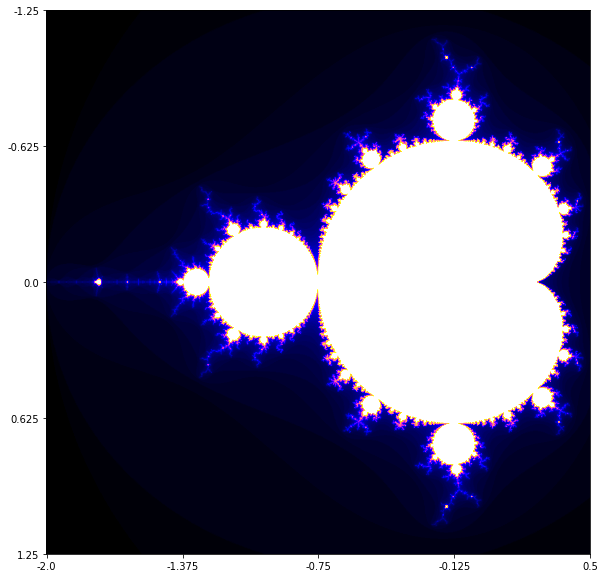

In [98]:
import time
import matplotlib.pyplot as plt

nx=1024
ny=1024

x_min = -2
x_max = 0.5
y_min = -1.25
y_max = 1.25

start = time.time()
img_width, img_height = 1000, 1000
gimage = np.zeros((img_width, img_height), dtype=np.uint8)


Z = generate_fractal()
dt = time.time() - start

print ("Mandelbrot created on GPU in %f s" % dt)

plt.figure(figsize=(10,10))
plt.imshow(Z, cmap = 'gnuplot2')

plt.xticks(np.linspace(0, nx, 5), np.linspace(x_min, x_max, 5));
plt.yticks(np.linspace(0, ny, 5), np.linspace(y_min, y_max, 5));